# <a id="top_section"></a>

<div align='center'><font size="5" color="#000000"><b>Fake News Detector<br>(~99.9% accuracy)</b></font></div>
<hr>
<div align='center'><font size="5" color="#000000">A General Introduction</font></div>
<hr>



## Table of Contents

* [Getting the Text Data Ready](#getting_the_data_ready)
* [Visualizing the Data](#visualize_data)
* [Cleaning the data](#clean_data)
* [Frequent Words](#wordcloud)
* [Tokenization](#tokenize)
* [Building our Model](#model)
* [Analyzing our Model](#analyze_model)
* [Some Last Words](#sectionlst)
    
## Summary
**In this kernel , I try to analyse and then build a model to predict whether the news given to us is fake or not<br>
I have used Glove embeddings and LSTM layers to get an accuracy of 99.9% on Train data and 99.8% on test data.If you want to check out some of my other projects , here is my GITHUB link :P**<br><br>
<a class="nav-link active"  style="background-color:; color:Blue"  href="https://github.com/friskycodeur" role="tab">Prateek Maheshwari on GITHUB</a>

<br>
<a href="https://ibb.co/nm4kTk1"><img src="https://bsmedia.business-standard.com/media-handler.php?mediaPath=https://bsmedia.business-standard.com/_media/bs/img/article/2020-03/16/full/1584358219-7432.jpg&width=1200" alt="Fake news picture" border="0" height=300 width=300></a>


### Here are the things I will try to cover in this Notebook:

- Basic EDA of the text data.
- Data cleaning
- Making some awesome Word clouds
- Using Glove embedding and tokenizer
- Building our model 

### I highly appreciate your feedback, there might be some areas can be fixed or improved.

## If you liked my work please dont forget to Upvote!

<a id="getting_the_data_ready"></a>
## Getting the Data Ready

<a id=01></a>
### Importing necessary libraries

**First off , we will import all the necessary libraries we need. <br> Apart from the basic libraries , I am using nltk,beautifulsoup,re,string to help with our text data. <br> For our model building i will be using embedding , lstm , dropout and dense layers.I will also be using ReduceLRonPlateau as callback. <br><br>
So let's import all of these libraries.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import STOPWORDS,WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata


from keras.preprocessing import text,sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

<a id='load_data'></a>
### Loading the data 

Having imported all the necessary libraries , now we will go ahead and load our data.

In [2]:
real_news=pd.read_csv('../input/fake-and-real-news-dataset/True.csv')
fake_news=pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')

Let's take a sneak peak at our data !

In [3]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


We will now combine both of these data and add a column of 'Isfake' so that we can use all the data as once and the 'Isfake' column will also be our target column , which will determine if the news is fake or not.

In [5]:
real_news['Isfake']=0
fake_news['Isfake']=1

Using conactenate function of pandas :

In [6]:
df=pd.concat([real_news,fake_news])

So how does our data look now ?

In [7]:
df.sample(5)

,title,text,subject,date,Isfake
19919,COMMUNIST George Soros Says Trump Will Win Pop...,George Soros: Here I have to confess to a lit...,left-news,"Sep 26, 2016",1
17566,BREAKING NEWS: Leftist Media Publishes Major F...,How many times in one week can ABC News publis...,left-news,"Dec 5, 2017",1
12093,"Brexit will not be derailed, says May ahead of...",LONDON (Reuters) - Prime Minister Theresa May ...,worldnews,"December 17, 2017",0
15561,Catalonia's ex-leader granted freedom to campa...,BRUSSELS/MADRID (Reuters) - Catalonia s former...,worldnews,"November 6, 2017",0
11132,LIBERAL MEDIA IGNORES MELANIA’S Visit To Home ...,"First Lady Melania Trump visits HomeSafe, phot...",politics,"Apr 15, 2017",1


Are there any null values?

In [8]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
Isfake     0
dtype: int64

As there are no null values , we are saved from the hassle of making up for the missing values. Now we will visualize the data.

<a id='visualize_data'></a>
## Visualizing the data 

How many of the given news are fake and how many of them are real?

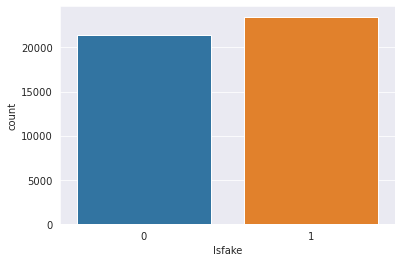

In [9]:
sns.countplot(df.Isfake)

The number of fake and real news are almost equal. <br>
Now let us see how many unqiue titles are there. Are any of the titles repeated?

In [10]:
df.title.count()

44898

How many subjects are there ? We can see that using value_counts()

In [11]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Let's see how much of the news in different subject are fake !

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

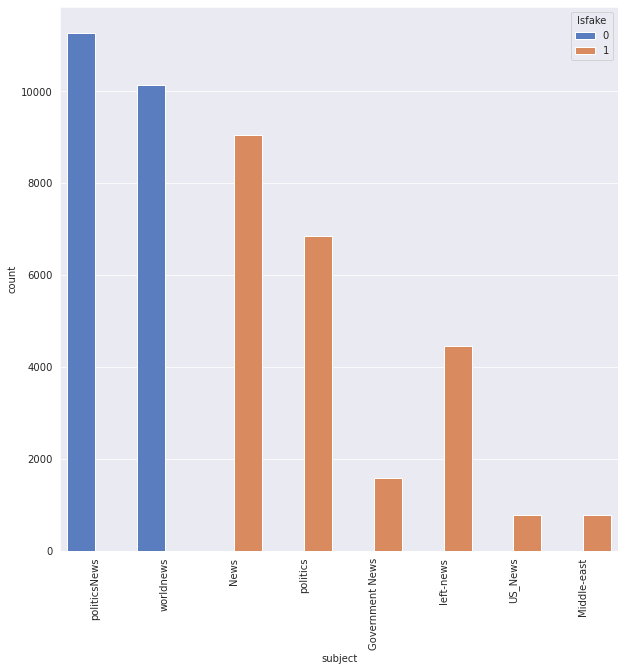

In [12]:
plt.figure(figsize=(10,10))
chart=sns.countplot(x='subject',hue='Isfake',data=df,palette='muted')
chart.set_xticklabels(chart.get_xticklabels(),rotation=90,fontsize=10)

Now we will place all of the required columns in one and delete all the not-so-required columns.

In [13]:
df['text']= df['text']+ " " + df['title']
del df['title']
del df['subject']
del df['date']

We are done with this now , we shall head towards cleaning our data!

<a id='clean_data'></a>
## Cleaning the data

<img src='https://i.pinimg.com/originals/f5/fb/5e/f5fb5efe6b9f1d5f11f19e69f67f5ccf.gif'>

Our data may consist URLs , HTML tags which might make it difficult for our model to predict properly. To prevent that from happening we will clean our data so as to make our model more efficient.

We will be removing punctuation , stopwords,URLS, html tags from our text data. <br>
For this we shall use beautifulsoup and re library which we imported earlier.

In [14]:
stop_words=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop_words.update(punctuation)

In [15]:
def string_html(text):
    soup=BeautifulSoup(text,"html.parser")
    return soup.get_text()

def remove_square_brackets(text):
    return re.sub('\[[^]]*\]','',text)

def remove_URL(text):
    return re.sub(r'http\S+','',text)

def remove_stopwords(text):
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

def clean_text_data(text):
    text=string_html(text)
    text=remove_square_brackets(text)
    text=remove_stopwords(text)
    text=remove_URL(text)
    return text

Now that we have defined the cleaning functions , let us use em' on our text data.

In [16]:
df['text']=df['text'].apply(clean_text_data)

We are all done with cleaning and have with us cleaned text data now.Next up are some awesome wordclouds.

<a id='wordcloud'></a>
## Frequent Words

I wonder what words were the most used in fake news and real news and i guess you do too!<br>
So let's see what these frequent words are , and for that we will use wordcloud.

Let's see the fake news texts first !

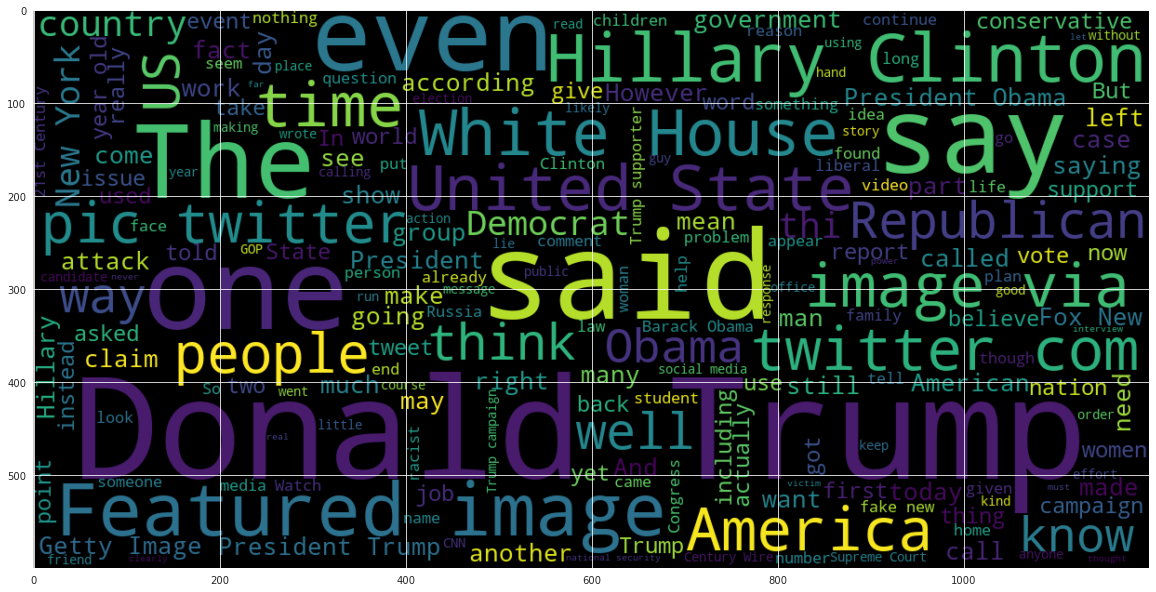

In [17]:
plt.figure(figsize=(20,20))
wordcloud=WordCloud(stopwords=STOPWORDS,height=600,width=1200).generate(" ".join(df[df.Isfake==1].text))
plt.imshow(wordcloud,interpolation='bilinear')

Now what about the real news?

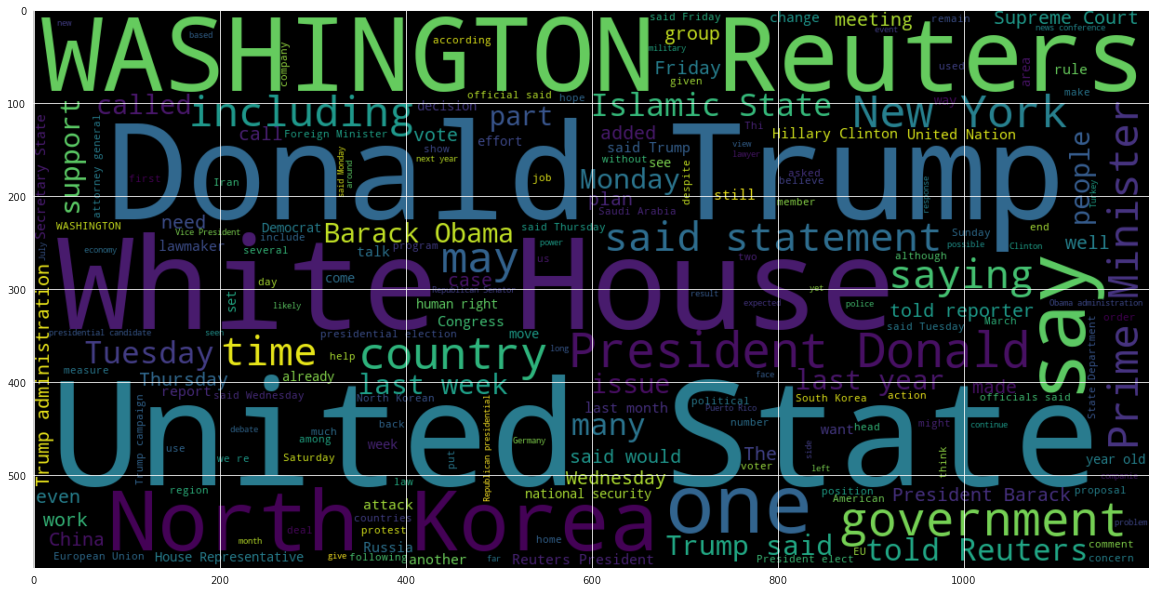

In [18]:
plt.figure(figsize=(20,20))
wordcloud=WordCloud(stopwords=STOPWORDS,height=600,width=1200).generate(" ".join(df[df.Isfake==0].text))
plt.imshow(wordcloud,interpolation='bilinear')

Those were some nice wordclouds , and clearly Donald Trump , United States , etc were very frequent.

<a id='tokenize'></a>
## Tokenization

We shall now tokenize our data ,i.e convert the text data into vectors.

In [19]:
X_train,X_test,y_train,y_test=train_test_split(df.text,df.Isfake,random_state=0)

In [20]:
max_features=10000
max_len=300

To tokinize our data , I am using tokenizer here. There are other ways to tokenize data , you can also try them out.

Here is what is happening in the next code tab:
- First we initialized the tokenizer with it's size being 10k.
- Then we fit the training data on this tokenizer.
- Then we convert the text to sequences and save it in X_train variable.
- Lastly we add a padding layer around our sequence.

Here is a example of what tokenizer does 
<img src='https://miro.medium.com/max/2414/1*UhfwmhMN9sdfcWIbO5_tGg.jpeg'>

In [21]:
tokenizer=text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenizer_train=tokenizer.texts_to_sequences(X_train)
X_train=sequence.pad_sequences(tokenizer_train,maxlen=max_len)

In [22]:
tokenizer_test=tokenizer.texts_to_sequences(X_test)
X_test=sequence.pad_sequences(tokenizer_test,maxlen=max_len)

Now we will import our GLOVE file , I am using the 100d version here.

In [23]:
glove_file='../input/glove-twitter/glove.twitter.27B.100d.txt'

Now we will get the coefficients from the glove file and save it in embedding index variable.

In [24]:
def get_coefs(word, *arr):
    return word, np.asarray(arr,dtype='float32')
embeddings_index=dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(glove_file,encoding="utf8"))

What's happening in the next code tab:
- We first take all the values of the embeddings and store it in all_embs.
- Then we take the mean and standard deviation of all the embeddings.
- We now take the word indices using .word_index function of tokenizer.
- Then we will see what the length of each vector would be and save it in nb_words.
- We make an embedding matrix.

In [25]:
all_embs=np.stack(embeddings_index.values())
emb_mean,emb_std=all_embs.mean(),all_embs.std()
emb_size=all_embs.shape[1]

word_index=tokenizer.word_index
nb_words=min(max_features,len(word_index))

embedding_matrix = np.random.normal(emb_mean,emb_std,(nb_words,emb_size))

for word,i in word_index.items():
    if i>=max_features: continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i]=embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


<a id='model'></a>
## Building our model

We have succesfully done the tokenization part , let's build our model now!<br>
Here are the parameters I'm taking.

In [26]:
batch_size=256
epochs=10
emb_size=100

Let's initialize our callback.

In [27]:
leaning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=10,factor=0.5,min_lr=0.00001)

Let's build our model.Here are the layers I'm using:
- Starting with an embedding layer
- Then 3 LSTM layers
- Then 2 Dense layers

I am using Adam optimizer for our model.

In [28]:
model=Sequential()
model.add(Embedding(max_features,output_dim=emb_size,weights=[embedding_matrix],input_length=max_len,trainable=False))
model.add(LSTM(units=256,return_sequences=True,recurrent_dropout=0.25,dropout=0.25))
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.25,dropout=0.25))
model.add(LSTM(units=64,recurrent_dropout=0.1,dropout=0.1))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(1,'sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 256)          365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,614,209
Trainable params: 614,209
Non-trainable params: 1,000,000
________________________________________

Let's train our model now !

In [30]:
history=model.fit(X_train,y_train,batch_size=batch_size,validation_data=(X_test,y_test),epochs=epochs,callbacks=[leaning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 452s 3s/step - loss: 0.3564 - accuracy: 0.8259 - val_loss: 0.0776 - val_accuracy: 0.9769 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 451s 3s/step - loss: 0.0360 - accuracy: 0.9894 - val_loss: 0.0184 - val_accuracy: 0.9933 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 458s 3s/step - loss: 0.0237 - accuracy: 0.9929 - val_loss: 0.0155 - val_accuracy: 0.9952 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 457s 3s/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0174 - val_accuracy: 0.9941 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 453s 3s/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0144 - val_accuracy: 0.9962 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - 460s 3s/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0117 - val_accuracy: 0.9972 - lr: 0.0100
Epoch 7/10
132/132 [==============================] - 461s 3s/st

Let's see our model in action ! ;)

In [31]:
pred = model.predict_classes(X_test)
pred[5:10]

array([[0],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

<a id='analyze_model'></a>
## Analyzing our model 

Let's see how the accuracy and loss graphs of our model look now !

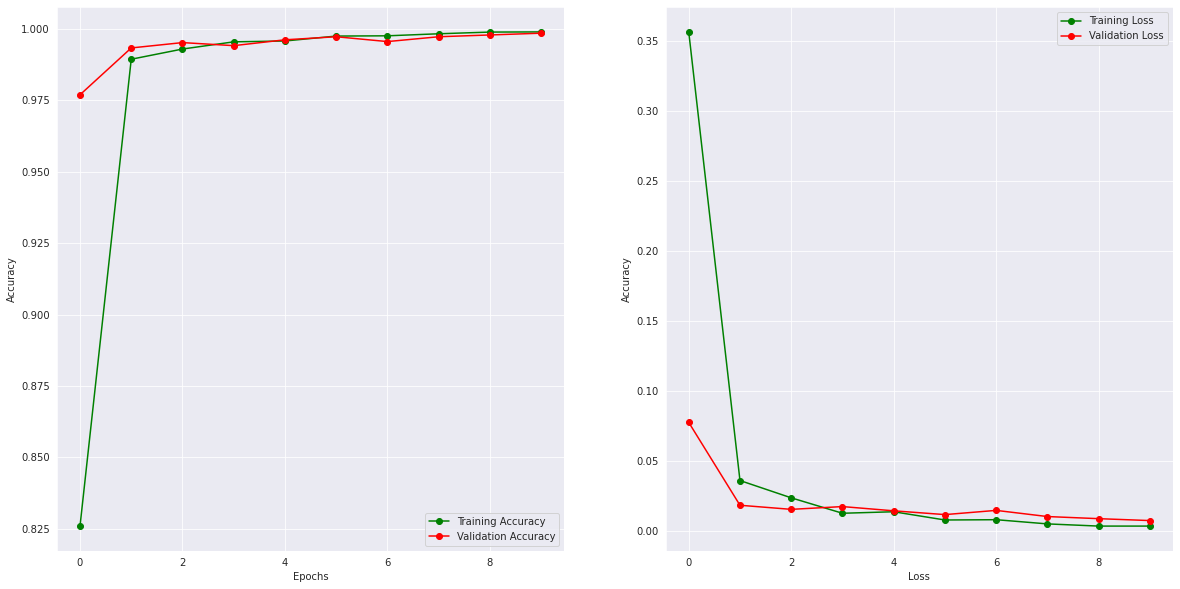

In [32]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs,train_acc,'go-',label='Training Accuracy')
ax[0].plot(epochs,val_acc,'ro-',label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs,train_loss,'go-',label='Training Loss')
ax[1].plot(epochs,val_loss,'ro-',label='Validation Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

We will now see how many of the samples were wrongly predicted using the confusion matrix. 

In [33]:
cm=confusion_matrix(y_test,pred)

In [34]:
cm=pd.DataFrame(cm,index=['Fake','Not Fake'],columns=['Fake','Not Fake'])

In [35]:
cm

,Fake,Not Fake
Fake,5353,14
Not Fake,3,5855


Text(69.0, 0.5, 'Predicted')

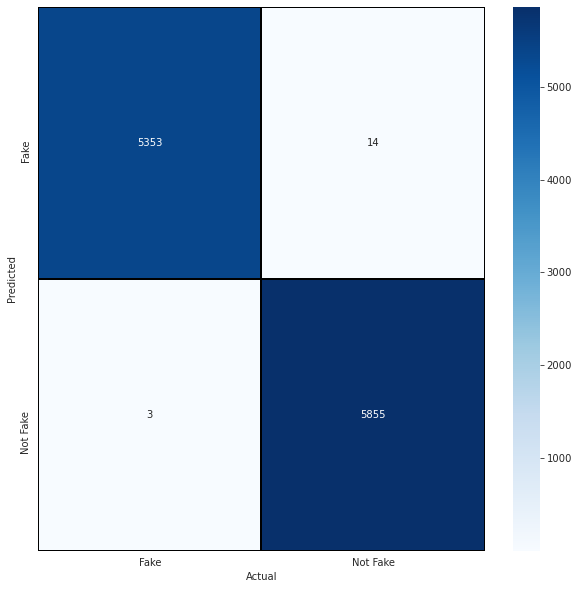

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,cmap="Blues",linecolor='black',linewidth=1,annot=True,fmt='',xticklabels=['Fake','Not Fake'],yticklabels=['Fake','Not Fake'])
plt.xlabel('Actual')
plt.ylabel('Predicted')

Now what is our accuracy on Test and Train set?


In [37]:
print(f'Accuracy of the model on Training Data is - { model.evaluate(X_train,y_train)[1]*100:.2f}')
print(f'Accuracy of the model on Testing Data is -  {model.evaluate(X_test,y_test)[1]*100:.2f}')

1053/1053 [==============================] - 219s 208ms/step - loss: 4.7703e-04 - accuracy: 0.9999
Accuracy of the model on Training Data is - 99.99
351/351 [==============================] - 72s 206ms/step - loss: 0.0075 - accuracy: 0.9985
Accuracy of the model on Testing Data is -  99.85


<a href="#top_section" class="btn btn-primary" style="color:white;" >Back to Table of Content</a>

# Some last words:

Thank you for reading! I'm still a beginner and want to improve myself in every way I can. So if you have any ideas to feedback please let me know in the comments section!


<div align='center'><font size="3" color="#000000"><b>And again please upvote if you liked this notebook so it can reach more people, Thanks!</b></font></div>

<img src='https://media.tenor.com/images/69d1d66198f1aac60ad244f6c004f372/tenor.gif'>